# Blade Element Momentum model

This is an example of implementation of a Blade Element Momentum model for application to an horizontal axis wind turbine and propeller:
1. in steady, uniform, axial flow.
2. implementing corrections for heavily loaded streamtubes.
3. implementing corrections for finite number of blades in a finite tip speed ratio.

## Tutorial support
In the *iframe* below, you can find the tutorial available at https://csimaoferreira.github.io/Rotor-Wake-Aerodynamics-BEM/#/

In [1]:
from IPython.display import IFrame

In [2]:
IFrame(src='https://csimaoferreira.github.io/Rotor-Wake-Aerodynamics-BEM/#/', width=1000, height=600)

## Definition of required functions

In [3]:
# import necessary libraries
import matplotlib.pyplot as plt
import numpy as np  

In [4]:
def CTfunction(a, glauert = False):
    """
    This function calculates the thrust coefficient as a function of induction factor 'a'
    'glauert' defines if the Glauert correction for heavily loaded rotors should be used; default value is false
    """
    CT = np.zeros(np.shape(a))
    CT = 4*a*(1-a)  
    if glauert:
        CT1=1.816;
        a1=1-np.sqrt(CT1)/2;
        CT[a>a1] = CT1-4*(np.sqrt(CT1)-1)*(1-a[a>a1])
    
    return CT
  
    
def ainduction(CT):
    """
    This function calculates the induction factor 'a' as a function of thrust coefficient CT 
    including Glauert's correction
    """
    a = np.zeros(np.shape(CT))
    CT1=1.816;
    CT2=2*np.sqrt(CT1)-CT1
    a[CT>=CT2] = 1 + (CT[CT>=CT2]-CT1)/(4*(np.sqrt(CT1)-1))
    a[CT<CT2] = 0.5-0.5*np.sqrt(1-CT[CT<CT2])
    return a

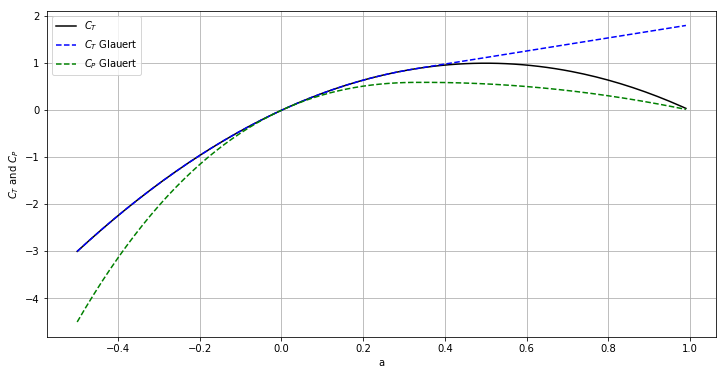

In [5]:
# plot CT as a function of induction "a", with and without Glauert correction
# define a as a range
a = np.arange(-.5,1,.01)
CTmom = CTfunction(a) # CT without correction
CTglauert = CTfunction(a, True) # CT with Glauert's correction
a2 = ainduction(CTglauert)

fig1 = plt.figure(figsize=(12, 6))
plt.plot(a, CTmom, 'k-', label='$C_T$')
plt.plot(a, CTglauert, 'b--', label='$C_T$ Glauert')
plt.plot(a, CTglauert*(1-a), 'g--', label='$C_P$ Glauert')
plt.xlabel('a')
plt.ylabel(r'$C_T$ and $C_P$')
plt.grid()
plt.legend()
plt.show()


In [6]:
def PrandtlTipRootCorrection(r_R, rootradius_R, tipradius_R, TSR, NBlades, axial_induction):
    """
    This function calcualte steh combined tip and root Prandtl correction at agiven radial position 'r_R' (non-dimensioned by rotor radius), 
    given a root and tip radius (also non-dimensioned), a tip speed ratio TSR, the number lf blades NBlades and the axial induction factor
    """
    temp1 = -NBlades/2*(tipradius_R-r_R)/r_R*np.sqrt( 1+ ((TSR*r_R)**2)/((1-axial_induction)**2))
    Ftip = np.array(2/np.pi*np.arccos(np.exp(temp1)))
    Ftip[np.isnan(Ftip)] = 0
    temp1 = NBlades/2*(rootradius_R-r_R)/r_R*np.sqrt( 1+ ((TSR*r_R)**2)/((1-axial_induction)**2))
    Froot = np.array(2/np.pi*np.arccos(np.exp(temp1)))
    Froot[np.isnan(Froot)] = 0
    return Froot*Ftip, Ftip, Froot


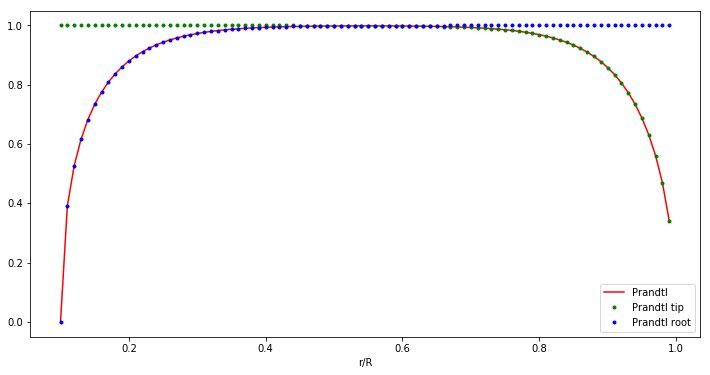

In [7]:
# plot Prandtl tip, root and combined correction for a number of blades and induction 'a', over the non-dimensioned radius
r_R = np.arange(0.1, 1, .01)
a = np.zeros(np.shape(r_R))+0.3
Prandtl, Prandtltip, Prandtlroot = PrandtlTipRootCorrection(r_R, 0.1, 1, 7, 3, a)

fig1 = plt.figure(figsize=(12, 6))
plt.plot(r_R, Prandtl, 'r-', label='Prandtl')
plt.plot(r_R, Prandtltip, 'g.', label='Prandtl tip')
plt.plot(r_R, Prandtlroot, 'b.', label='Prandtl root')
plt.xlabel('r/R')
plt.legend()
plt.show()




In [8]:
# import polar

import pandas as pd

airfoil = 'DU95W180.cvs'
data1=pd.read_csv(airfoil, header=0,
                    names = ["alfa", "cl", "cd", "cm"],  sep='\s+')
polar_alpha = data1['alfa'][:]
polar_cl = data1['cl'][:]
polar_cd = data1['cd'][:]


# airfoil = 'ARAD8polar.csv'
# data1=pd.read_csv(airfoil, header=0,
#                     names = ["alfa", "cl", "cd", "cm"],  sep='\s+')

# polar_alpha = np.flipud(-data1['alfa'][:])
# polar_cl = np.flipud(-data1['cl'][:])
# polar_cd = np.flipud(data1['cd'][:])

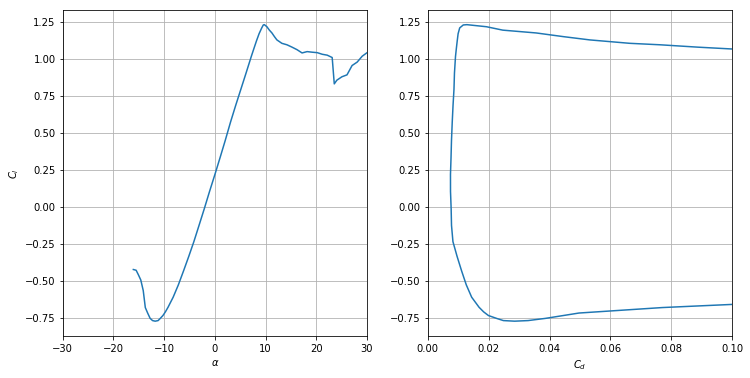

In [9]:
# plot polars of the airfoil C-alfa and Cl-Cd

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(polar_alpha, polar_cl)
axs[0].set_xlim([-30,30])
axs[0].set_xlabel(r'$\alpha$')
axs[0].set_ylabel(r'$C_l$')
axs[0].grid()
axs[1].plot(polar_cd, polar_cl)
axs[1].set_xlim([0,.1])
axs[1].set_xlabel(r'$C_d$')
axs[1].grid()
plt.show()

In [10]:
# define function to determine load in the blade element
def loadBladeElement(vnorm, vtan, r_R, chord, twist, polar_alpha, polar_cl, polar_cd):
    """
    calculates the load in the blade element
    """
    vmag2 = vnorm**2 + vtan**2
    inflowangle = np.arctan2(vnorm,vtan)
    alpha = twist + inflowangle*180/np.pi
    cl = np.interp(alpha, polar_alpha, polar_cl)
    cd = np.interp(alpha, polar_alpha, polar_cd)
    lift = 0.5*vmag2*cl*chord
    drag = 0.5*vmag2*cd*chord
    fnorm = lift*np.cos(inflowangle)+drag*np.sin(inflowangle)
    ftan = lift*np.sin(inflowangle)-drag*np.cos(inflowangle)
    gamma = 0.5*np.sqrt(vmag2)*cl*chord
    return fnorm , ftan, gamma

def solveStreamtube(Uinf, r1_R, r2_R, rootradius_R, tipradius_R , Omega, Radius, NBlades, chord, twist, polar_alpha, polar_cl, polar_cd ):
    """
    solve balance of momentum between blade element load and loading in the streamtube
    input variables:
    Uinf - wind speed at infinity
    r1_R,r2_R - edges of blade element, in fraction of Radius ;
    rootradius_R, tipradius_R - location of blade root and tip, in fraction of Radius ;
    Radius is the rotor radius
    Omega -rotational velocity
    NBlades - number of blades in rotor
    """
    Area = np.pi*((r2_R*Radius)**2-(r1_R*Radius)**2) #  area streamtube
    r_R = (r1_R+r2_R)/2 # centroide
    # initiatlize variables
    a = 0.0 # axial induction
    aline = 0.0 # tangential induction factor
    
    Niterations = 100
    Erroriterations =0.00001 # error limit for iteration rpocess, in absolute value of induction
    
    for i in range(Niterations):
        # ///////////////////////////////////////////////////////////////////////
        # // this is the block "Calculate velocity and loads at blade element"
        # ///////////////////////////////////////////////////////////////////////
        Urotor = Uinf*(1-a) # axial velocity at rotor
        Utan = (1+aline)*Omega*r_R*Radius # tangential velocity at rotor
        # calculate loads in blade segment in 2D (N/m)
        fnorm, ftan, gamma = loadBladeElement(Urotor, Utan, r_R,chord, twist, polar_alpha, polar_cl, polar_cd)
        load3Daxial =fnorm*Radius*(r2_R-r1_R)*NBlades # 3D force in axial direction
        # load3Dtan =loads[1]*Radius*(r2_R-r1_R)*NBlades # 3D force in azimuthal/tangential direction (not used here)
      
        # ///////////////////////////////////////////////////////////////////////
        # //the block "Calculate velocity and loads at blade element" is done
        # ///////////////////////////////////////////////////////////////////////

        # ///////////////////////////////////////////////////////////////////////
        # // this is the block "Calculate new estimate of axial and azimuthal induction"
        # ///////////////////////////////////////////////////////////////////////
        # // calculate thrust coefficient at the streamtube 
        CT = load3Daxial/(0.5*Area*Uinf**2)
        
        # calculate new axial induction, accounting for Glauert's correction
        anew =  ainduction(CT)
        
        # correct new axial induction with Prandtl's correction
        Prandtl, Prandtltip, Prandtlroot = PrandtlTipRootCorrection(r_R, rootradius_R, tipradius_R, Omega*Radius/Uinf, NBlades, anew);
        if (Prandtl < 0.0001): 
            Prandtl = 0.0001 # avoid divide by zero
        anew = anew/Prandtl # correct estimate of axial induction
        a = 0.75*a+0.25*anew # for improving convergence, weigh current and previous iteration of axial induction

        # calculate aximuthal induction
        aline = ftan*NBlades/(2*np.pi*Uinf*(1-a)*Omega*2*(r_R*Radius)**2)
        aline =aline/Prandtl # correct estimate of azimuthal induction with Prandtl's correction
        # ///////////////////////////////////////////////////////////////////////////
        # // end of the block "Calculate new estimate of axial and azimuthal induction"
        # ///////////////////////////////////////////////////////////////////////
        
        #// test convergence of solution, by checking convergence of axial induction
        if (np.abs(a-anew) < Erroriterations): 
            # print("iterations")
            # print(i)
            break

    return [a , aline, r_R, fnorm , ftan, gamma]

In [11]:
# define the blade geometry
delta_r_R = .01
r_R = np.arange(0.2, 1+delta_r_R/2, delta_r_R)

# blade shape
pitch = 2 # degrees
chord_distribution = 3*(1-r_R)+1 # meters
twist_distribution = -14*(1-r_R)+pitch # degrees

pitch = 2 # degrees
chord_distribution = 0.18-0.06*(r_R) # meters
twist_distribution = 0.*(-50*(r_R)+35.5+ 45.5) # degrees



# define flow conditions
Uinf = 1 # unperturbed wind speed in m/s
TSR = 8 # tip speed ratio
Radius = 50
Omega = Uinf*TSR/Radius
NBlades = 3


Uinf = 60 # unperturbed wind speed in m/s
Radius = 0.7
Omega = 1200/60*2*np.pi
NBlades = 4

# solve BEM model


results =np.zeros([len(r_R)-1,6]) 

for i in range(len(r_R)-1):
    chord = np.interp((r_R[i]+r_R[i+1])/2, r_R, chord_distribution)
    twist = np.interp((r_R[i]+r_R[i+1])/2, r_R, twist_distribution)
    
    results[i,:] = solveStreamtube(Uinf, r_R[i], r_R[i+1], r_R[0], r_R[-1] , Omega, Radius, NBlades, chord, twist, polar_alpha, polar_cl, polar_cd )

In [12]:
# plot results


areas = (r_R[1:]**2-r_R[:-1]**2)*np.pi*Radius**2
dr = (r_R[1:]-r_R[:-1])*Radius
CT = np.sum(dr*results[:,3]*NBlades/(0.5*Uinf**2*np.pi*Radius**2))
CP = np.sum(dr*results[:,4]*results[:,2]*NBlades*Radius*Omega/(0.5*Uinf**3*np.pi*Radius**2))


print("CT is ", CT)
print("CP is ", CP)



CT is  0.3852403180782167
CP is  0.038796183231045105


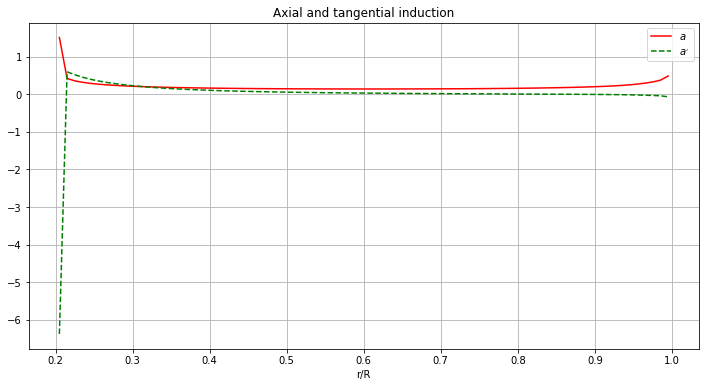

In [13]:


fig1 = plt.figure(figsize=(12, 6))
plt.title('Axial and tangential induction')
plt.plot(results[:,2], results[:,0], 'r-', label=r'$a$')
plt.plot(results[:,2], results[:,1], 'g--', label=r'$a^,$')
plt.grid()
plt.xlabel('r/R')
plt.legend()
plt.show()

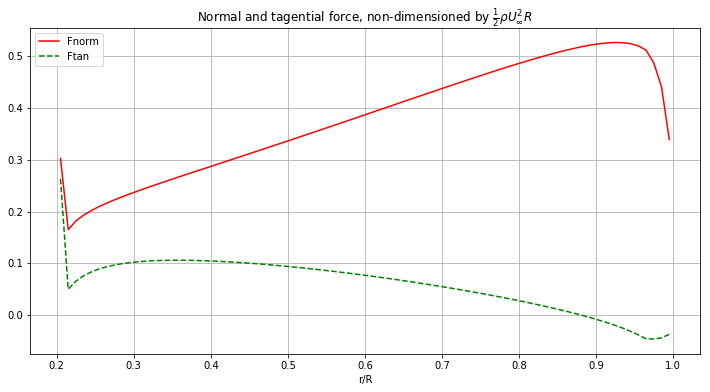

In [14]:
fig1 = plt.figure(figsize=(12, 6))
plt.title(r'Normal and tagential force, non-dimensioned by $\frac{1}{2} \rho U_\infty^2 R$')
plt.plot(results[:,2], results[:,3]/(0.5*Uinf**2*Radius), 'r-', label=r'Fnorm')
plt.plot(results[:,2], results[:,4]/(0.5*Uinf**2*Radius), 'g--', label=r'Ftan')
plt.grid()
plt.xlabel('r/R')
plt.legend()
plt.show()

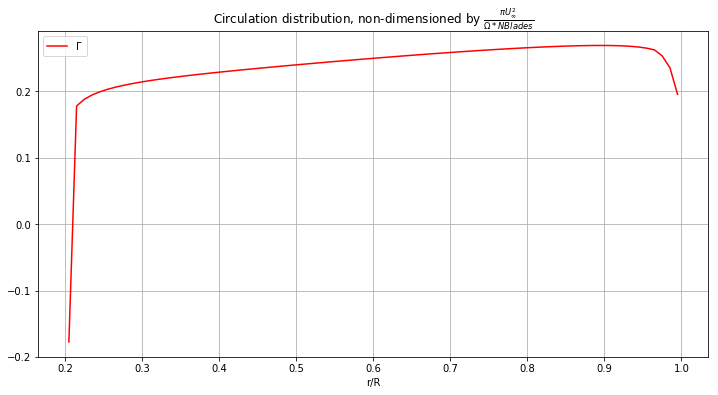

In [15]:
fig1 = plt.figure(figsize=(12, 6))
plt.title(r'Circulation distribution, non-dimensioned by $\frac{\pi U_\infty^2}{\Omega * NBlades } $')
plt.plot(results[:,2], results[:,5]/(np.pi*Uinf**2/(NBlades*Omega)), 'r-', label=r'$\Gamma$')
plt.grid()
plt.xlabel('r/R')
plt.legend()
plt.show()